<a href="https://colab.research.google.com/github/CryptoVizArt/kiboMoney_riskDashboard_streamlit/blob/main/kibo_sample_signalExtraction_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieved data for 4 metrics across 1534 dates
            date-to-realized-cap  \
date                               
2021-01-01          1.729444e+11   
2021-01-02          1.759768e+11   
2021-01-03          1.791336e+11   
2021-01-04          1.818415e+11   
2021-01-05          1.845234e+11   

            date-to-supply-in-profit-to-circulating-supply-ratio  \
date                                                               
2021-01-01                                          97.979227      
2021-01-02                                          98.036590      
2021-01-03                                          98.227691      
2021-01-04                                          99.095707      
2021-01-05                                          97.378188      

            date-to-market-cap  date-to-realized-profit-to-loss-1d-sum-ratio  
date                                                                          
2021-01-01        5.382895e+11                                   

<ipython-input-8-bcadef50180d>:407: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(color_map)


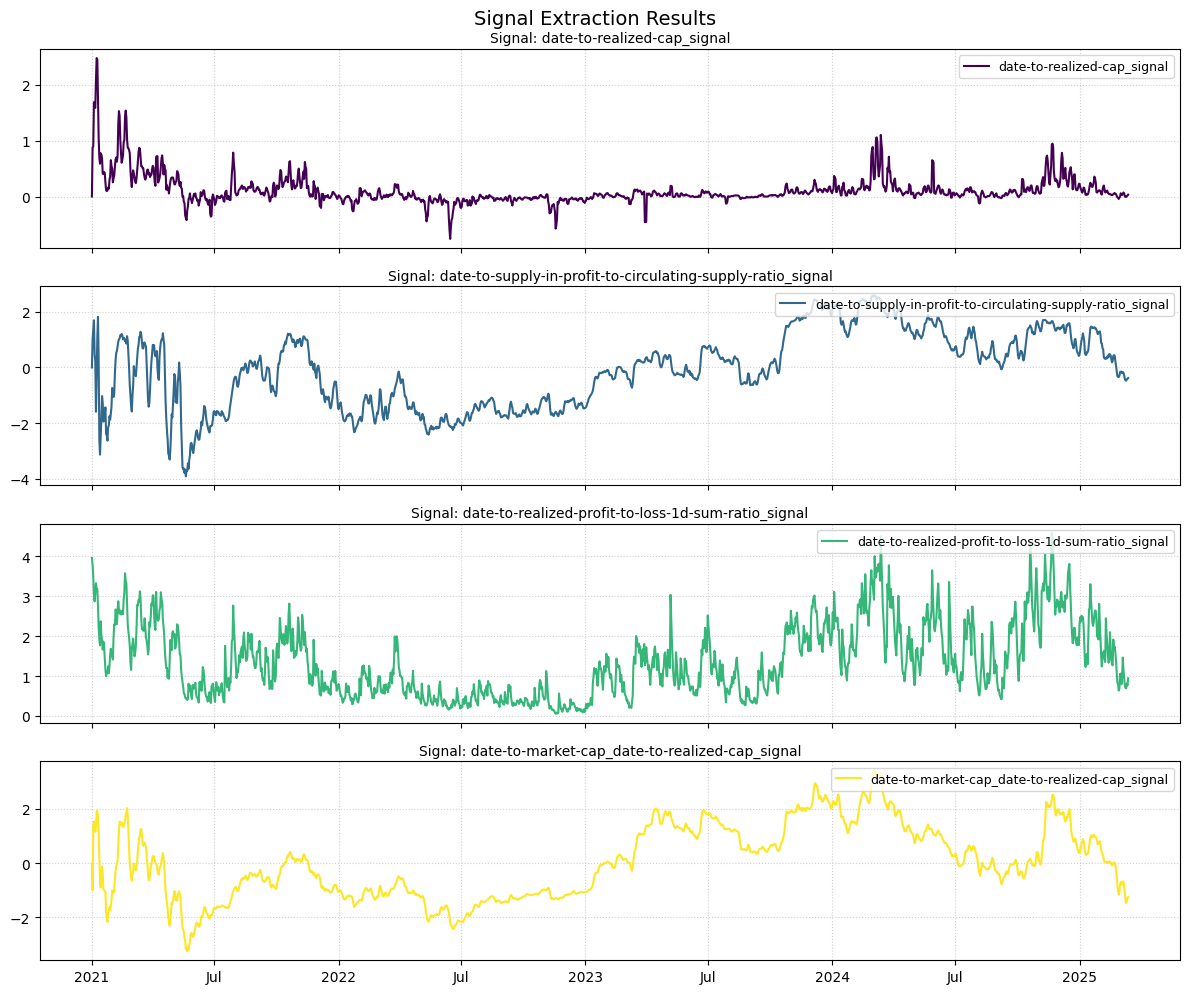

In [8]:
import requests
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
from scipy import signal
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap

def fetch_single_data(url, start_date="2023-01-01", end_date="2025-03-14"):
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])
    years = list(range(start_year, end_year + 1))

    all_data = {}

    for year in years:
        api_url = f"{url}?chunk={year}"
        try:
            response = requests.get(api_url)
            data = response.json()
            if 'dataset' in data and 'map' in data['dataset']:
                all_data.update(data['dataset']['map'])
        except Exception:
            pass

    if all_data:
        df = pd.DataFrame({
            'date': list(all_data.keys()),
            'value': list(all_data.values())
        })
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= pd.to_datetime(start_date)) &
                (df['date'] <= pd.to_datetime(end_date))]
        df = df.sort_values('date').reset_index(drop=True)
        return df

    return pd.DataFrame(columns=['date', 'value'])

def fetch_all_metrics(metrics_urls, start_date="2023-01-01", end_date="2025-03-14"):
    # Dictionary to hold all dataframes
    metric_dfs = {}

    for url in metrics_urls:
        metric_name = url.split('/')[-1]
        df = fetch_single_data(url, start_date, end_date)

        if not df.empty:
            # Store dataframe with metric name as key
            metric_dfs[metric_name] = df.set_index('date')['value']

    if metric_dfs:
        # Combine all series side by side with date as index
        raw_data = pd.DataFrame(metric_dfs)
        return raw_data

    return pd.DataFrame()

def extract_signals(raw_data, signal_config):
    """
    Extract signals from a data frame using specified calculations, smoothing, and normalization methods.
    """
    result_df = pd.DataFrame(index=raw_data.index)

    for col_key, config in signal_config.items():
        # Parse configuration
        indicator_formula, smoothing_method, smoothing_window, normalization_method, normalization_window = config

        # Step 1: Calculate the indicator using the formula
        if isinstance(col_key, (list, tuple)):
            # If multiple columns are specified, extract them
            required_cols = raw_data[list(col_key)]
            # Include raw_data in the evaluation context
            eval_context = {
                "raw_data": raw_data,  # Add raw_data to the context
                "np": np
            }
            # Add individual columns to context
            for col in required_cols.columns:
                eval_context[col] = required_cols[col]

            # Evaluate the formula with raw_data in context
            indicator_series = eval(indicator_formula, {"__builtins__": {}}, eval_context)
        else:
            # If a single column is specified
            indicator_series = eval(indicator_formula.replace("column", f"raw_data['{col_key}']"),
                                   {"__builtins__": {}, "raw_data": raw_data, "np": np})

        # Step 2: Apply smoothing method
        smoothed_series = apply_smoothing(indicator_series, smoothing_method, smoothing_window)

        # Step 3: Apply normalization method
        normalized_series = apply_normalization(smoothed_series, normalization_method, normalization_window)

        # Add to result dataframe
        signal_name = f"{col_key}_signal"
        if isinstance(col_key, (list, tuple)):
            signal_name = f"{'_'.join(col_key)}_signal"
        result_df[signal_name] = normalized_series

    return result_df

def apply_smoothing(series, method, window):
    """Apply the specified smoothing method to the series"""
    if pd.isna(method) or method is None or method.lower() == 'none':
        return series

    # Ensure window is an integer for methods that require it
    if window is not None and not pd.isna(window):
        window = int(window)

    # Moving Average Methods
    if method.lower() == 'sma':
        return series.rolling(window=window, min_periods=1).mean()

    elif method.lower() == 'wma':
        weights = np.arange(1, window + 1)
        return series.rolling(window=window, min_periods=1).apply(
            lambda x: np.sum(weights * x) / np.sum(weights[:len(x)]), raw=True)

    elif method.lower() == 'ema':
        return series.ewm(span=window, min_periods=1, adjust=False).mean()

    elif method.lower() == 'hma':
        # Hull Moving Average: WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
        half_window = max(window // 2, 1)
        wma_n = series.rolling(window=window, min_periods=1).apply(
            lambda x: np.sum(np.arange(1, len(x) + 1) * x) / np.sum(np.arange(1, len(x) + 1)), raw=True)
        wma_half = series.rolling(window=half_window, min_periods=1).apply(
            lambda x: np.sum(np.arange(1, len(x) + 1) * x) / np.sum(np.arange(1, len(x) + 1)), raw=True)
        hull_series = 2 * wma_half - wma_n
        sqrt_window = max(int(np.sqrt(window)), 1)
        return hull_series.rolling(window=sqrt_window, min_periods=1).apply(
            lambda x: np.sum(np.arange(1, len(x) + 1) * x) / np.sum(np.arange(1, len(x) + 1)), raw=True)

    # Regression-Based Methods
    elif method.lower() == 'linear_regression':
        smoothed = series.copy()
        for i in range(len(series) - window + 1):
            y = series.iloc[i:i+window].values
            x = np.arange(len(y))
            slope, intercept, _, _, _ = stats.linregress(x, y)
            smoothed.iloc[i+window-1] = intercept + slope * (window - 1)
        # Fill NaN values at the beginning
        if window > 1:
            for i in range(window - 1):
                y = series.iloc[:i+1].values
                if len(y) > 1:  # Need at least 2 points for regression
                    x = np.arange(len(y))
                    slope, intercept, _, _, _ = stats.linregress(x, y)
                    smoothed.iloc[i] = intercept + slope * i
                else:
                    smoothed.iloc[i] = series.iloc[i]
        return smoothed

    elif method.lower() in ['loess', 'lowess']:
        # LOWESS smoothing
        # For a more accurate implementation, convert window to fraction
        fraction = min(max(window / len(series), 0.05), 1.0)
        result = lowess(series.values, np.arange(len(series)), frac=fraction, return_sorted=False)
        return pd.Series(result, index=series.index)

    elif method.lower() == 'polynomial':
        # Polynomial regression smoothing
        degree = min(3, window - 1)  # Degree of polynomial, default to cubic or less
        smoothed = series.copy()
        x = np.arange(len(series))

        # Fit polynomial to entire series
        coeffs = np.polyfit(x, series.values, degree)
        smoothed_values = np.polyval(coeffs, x)
        return pd.Series(smoothed_values, index=series.index)

    # Filter-Based Methods
    elif method.lower() == 'kalman':
        # Simple Kalman filter implementation
        smoothed = series.copy()
        n = len(series)
        # State transition model
        A = 1
        # Observation model
        H = 1
        # Process noise
        Q = 0.01
        # Observation noise (higher for more smoothing)
        R = max(0.1, 1.0 / window)

        # Initial state estimate
        x_hat = series.iloc[0]
        # Initial error covariance
        P = 1.0

        for i in range(n):
            # Predict
            x_hat_minus = A * x_hat
            P_minus = A * P * A + Q

            # Update
            K = P_minus * H / (H * P_minus * H + R)
            x_hat = x_hat_minus + K * (series.iloc[i] - H * x_hat_minus)
            P = (1 - K * H) * P_minus

            smoothed.iloc[i] = x_hat

        return smoothed

    elif method.lower() == 'hodrick_prescott' or method.lower() == 'hp':
        # Hodrick-Prescott filter
        # Lambda parameter based on window size (higher lambda = smoother trend)
        lambda_param = max(1600, window * 100)
        cycle, trend = hpfilter(series, lamb=lambda_param)
        return trend

    # Statistical Methods
    elif method.lower() == 'arima':
        # Simple ARIMA implementation
        # Using auto_arima would be better but requires pmdarima
        try:
            # Using a simple (1,1,1) ARIMA model
            model = sm.tsa.ARIMA(series, order=(1, 1, 1))
            results = model.fit()
            return results.fittedvalues
        except:
            # Fallback to EMA if ARIMA fails
            return series.ewm(span=window, min_periods=1, adjust=False).mean()

    elif method.lower() == 'kernel':
        # Gaussian kernel smoothing
        window_vals = np.arange(-window//2, window//2 + 1)
        kernel = np.exp(-(window_vals**2) / (2 * (window/4)**2))
        kernel = kernel / np.sum(kernel)

        # Apply convolution for smoothing
        smoothed_values = np.convolve(series.fillna(method='ffill').fillna(method='bfill').values,
                                      kernel, mode='same')
        return pd.Series(smoothed_values, index=series.index)

    # If method not recognized, return original series
    return series

def apply_normalization(series, method, window):
    """Apply the specified normalization method to the series"""
    if pd.isna(method) or method is None or method.lower() == 'none':
        return series

    # Ensure window is an integer for methods that require it
    if window is not None and not pd.isna(window):
        window = int(window)
    else:
        window = len(series)  # Default to full series length

    # Statistical Normalization Methods
    if method.lower() == 'z_score' or method.lower() == 'zscore':
        if window == len(series):
            # Global Z-score
            return (series - series.mean()) / series.std(ddof=0)
        else:
            # Rolling Z-score
            means = series.rolling(window=window, min_periods=1).mean()
            stds = series.rolling(window=window, min_periods=1).std(ddof=0)
            # Prevent division by zero
            stds = stds.replace(0, np.nan).fillna(1)
            return (series - means) / stds

    elif method.lower() == 'modified_z_score':
        if window == len(series):
            # Global modified Z-score
            median = series.median()
            mad = (series - median).abs().median()
            mad = mad if mad != 0 else 1  # Prevent division by zero
            return 0.6745 * (series - median) / mad
        else:
            # Rolling modified Z-score
            medians = series.rolling(window=window, min_periods=1).median()
            # Calculate rolling MAD
            def rolling_mad(x):
                return (x - x.median()).abs().median()
            mads = series.rolling(window=window, min_periods=1).apply(
                rolling_mad, raw=False)
            # Prevent division by zero
            mads = mads.replace(0, np.nan).fillna(1)
            return 0.6745 * (series - medians) / mads

    elif method.lower() == 'min_max' or method.lower() == 'minmax':
        if window == len(series):
            # Global min-max scaling
            min_val = series.min()
            max_val = series.max()
            if min_val == max_val:
                return pd.Series(0.5, index=series.index)  # All values are the same
            return (series - min_val) / (max_val - min_val)
        else:
            # Rolling min-max scaling
            mins = series.rolling(window=window, min_periods=1).min()
            maxs = series.rolling(window=window, min_periods=1).max()
            # Handle case where min equals max
            denom = (maxs - mins).replace(0, np.nan).fillna(1)
            return (series - mins) / denom

    elif method.lower() == 'robust_scaling':
        if window == len(series):
            # Global robust scaling using 5% and 95% quantiles
            q1 = series.quantile(0.05)
            q3 = series.quantile(0.95)
            if q1 == q3:
                return pd.Series(0.5, index=series.index)  # Distribution too narrow
            return (series - q1) / (q3 - q1)
        else:
            # Rolling robust scaling
            def rolling_quantile(x, q):
                return x.quantile(q)

            q1s = series.rolling(window=window, min_periods=1).apply(
                lambda x: rolling_quantile(x, 0.05), raw=False)
            q3s = series.rolling(window=window, min_periods=1).apply(
                lambda x: rolling_quantile(x, 0.95), raw=False)

            # Handle case where q1 equals q3
            denom = (q3s - q1s).replace(0, np.nan).fillna(1)
            return (series - q1s) / denom

    elif method.lower() == 'deviation_from_mean':
        if window == len(series):
            # Global deviation from mean
            return series - series.mean()
        else:
            # Rolling deviation from mean
            means = series.rolling(window=window, min_periods=1).mean()
            return series - means

    # Non-Stationary Time Series Normalization Methods
    elif method.lower() == 'differencing':
        # First-order differencing
        return series.diff().fillna(0)

    elif method.lower() == 'percentage_change':
        # Percentage change
        pct_change = series.pct_change().fillna(0) * 100
        # Replace infinite values with large but finite numbers
        pct_change = pct_change.replace([np.inf, -np.inf], [10000, -10000])
        return pct_change

    elif method.lower() == 'log_transform':
        # Log transformation (with small constant to handle zeros/negatives)
        min_val = min(series.min(), 0)
        offset = 1 - min_val if min_val <= 0 else 0
        return np.log(series + offset)

    elif method.lower() == 'box_cox':
        # Box-Cox transformation (auto-find lambda)
        min_val = min(series.min(), 0)
        offset = 1 - min_val if min_val <= 0 else 0
        adjusted_series = series + offset

        # Find optimal lambda between -2 and 2
        lambda_seq = np.linspace(-2, 2, 100)
        _, lambda_value = stats.boxcox(adjusted_series, lmbda=lambda_seq)

        # Apply Box-Cox with found lambda
        if abs(lambda_value) < 1e-10:  # Close to zero
            return np.log(adjusted_series)
        else:
            return (adjusted_series ** lambda_value - 1) / lambda_value

    elif method.lower() == 'detrending':
        # Linear detrending
        x = np.arange(len(series))
        slope, intercept, _, _, _ = stats.linregress(x, series.values)
        trend = pd.Series(intercept + slope * x, index=series.index)
        return series - trend

    elif method.lower() == 'rolling_normalization':
        # Rolling window Z-score normalization
        means = series.rolling(window=window, min_periods=1).mean()
        stds = series.rolling(window=window, min_periods=1).std(ddof=0)
        # Prevent division by zero
        stds = stds.replace(0, np.nan).fillna(1)
        return (series - means) / stds

    # If method not recognized, return original series
    return series

def plot_signals(signals, raw_data=None, figsize=(12, 15), color_map='viridis', grid=True,
               title='Signal Extraction Results', date_column=None):
    """
    Plot extracted signals in multiple stacked charts.
    """
    # Get number of signals to plot
    n_signals = len(signals.columns)

    if n_signals == 0:
        print("No signals to plot")
        return None

    # Create figure and axes
    fig, axes = plt.subplots(n_signals, 1, figsize=figsize, sharex=True)

    # If only one signal, axes won't be an array
    if n_signals == 1:
        axes = [axes]

    # Get colormap
    cmap = get_cmap(color_map)
    colors = [cmap(i/max(1, n_signals-1)) for i in range(n_signals)]

    # Prepare x-axis data
    if date_column is not None and raw_data is not None and date_column in raw_data.columns:
        x_data = raw_data[date_column]
        x_is_date = pd.api.types.is_datetime64_any_dtype(x_data)
    else:
        x_data = signals.index
        x_is_date = pd.api.types.is_datetime64_any_dtype(x_data)

    # Plot each signal
    for i, col in enumerate(signals.columns):
        ax = axes[i]

        # Plot the signal
        ax.plot(x_data, signals[col], color=colors[i], linewidth=1.5, label=col)

        # Add original data if available (as a light gray line)
        if raw_data is not None and col in raw_data.columns:
            ax.plot(x_data, raw_data[col], color='lightgray', linestyle='--', alpha=0.6,
                   linewidth=1, label=f'Original {col}')

        # Configure plot
        ax.set_title(f'Signal: {col}', fontsize=10, pad=5)
        ax.grid(grid, linestyle=':', alpha=0.6)
        ax.legend(loc='upper right', fontsize=9)

        # Format y-axis
        formatter = plt.ScalarFormatter(useOffset=False)
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)

        # Customize for time series data
        if x_is_date:
            locator = mdates.AutoDateLocator()
            formatter = mdates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)

    # Set main title
    fig.suptitle(title, fontsize=14, y=0.99)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    return fig

# Example usage:
METRICS = [
    "https://kibo.money/api/date-to-realized-cap",
    "https://kibo.money/api/date-to-supply-in-profit-to-circulating-supply-ratio",
    "https://kibo.money/api/date-to-market-cap",
    "https://kibo.money/api/date-to-realized-profit-to-loss-1d-sum-ratio"
]

start_date = "2021-01-01"
end_date = "2025-03-14"

raw_data = fetch_all_metrics(METRICS, start_date, end_date)
print(f"Retrieved data for {raw_data.shape[1]} metrics across {raw_data.shape[0]} dates")
print(raw_data.head())

# Signal configuration
signal_config = {
    'date-to-realized-cap': ['column', 'sma', 3, 'percentage_change', 30],
    'date-to-supply-in-profit-to-circulating-supply-ratio': ['column', 'sma', 3, 'z_score', 730],
    'date-to-realized-profit-to-loss-1d-sum-ratio': ['column', 'ema', 3, 'log_transform', 30],
    ('date-to-market-cap','date-to-realized-cap'): ['raw_data["date-to-market-cap"]/raw_data["date-to-realized-cap"]', 'sma', 3, 'z_score', 365]
}

# Extract signals
signals = extract_signals(raw_data, signal_config)

# Plot signals
fig = plot_signals(signals, raw_data, figsize=(12, 10), date_column='date')
plt.show()